# Late Fusion
## Modality 3: Health information

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2_data_preprocessing/output/'

output_path = '../output/'

# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
train_df = pd.read_csv(os.path.join(input_path, 'train_m3_encoded_df.csv'))

In [5]:
train_df

,ob_diag,dm_diag,hbp_diag,cvd_ha_hi,cvd_chest_angina,cvd_heart_failure,kd_diag_uti,kd_diag_k_stones,kd_diag_renal_fail,chol_diag,...,age_group_health_info_adult_30-39,age_group_health_info_adult_40-49,age_group_health_info_adult_50-59,age_group_health_info_adult_60-69,age_group_health_info_adult_70-79,age_group_health_info_adult_80-89,sex_health_info_adult_female,sex_health_info_adult_male,label,group
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3
3379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,5
3380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
3381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1


In [6]:
from sklearn.utils import shuffle

train_shuffled_df = shuffle(train_df, random_state=seed).reset_index(drop=True)

In [7]:
train_shuffled_df

,ob_diag,dm_diag,hbp_diag,cvd_ha_hi,cvd_chest_angina,cvd_heart_failure,kd_diag_uti,kd_diag_k_stones,kd_diag_renal_fail,chol_diag,...,age_group_health_info_adult_30-39,age_group_health_info_adult_40-49,age_group_health_info_adult_50-59,age_group_health_info_adult_60-69,age_group_health_info_adult_70-79,age_group_health_info_adult_80-89,sex_health_info_adult_female,sex_health_info_adult_male,label,group
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,5
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3378,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
3379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,5
3380,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3
3381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,5


## Other functions

In [8]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([2,2])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(label_id_to_label_num.keys()), list(label_id_to_label_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Elastic Net SGD Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_m3.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m3.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_m3.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
SGDClassifier(alpha=0.05, class_weight='balanced', loss='log', max_iter=2500,
              n_iter_no_change=150, penalty='elasticnet', random_state=27)


In [10]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
731,1.059517,0.741623,0.004601,0.000490,0.05,balanced,0.15,log,2500,150,...,27,"{'alpha': 0.05, 'class_weight': 'balanced', 'l...",0.572457,0.567179,0.584987,0.591471,0.596735,0.582566,0.011179,1
726,1.146135,0.822956,0.011401,0.012799,0.05,balanced,0.1,log,2500,100,...,27,"{'alpha': 0.05, 'class_weight': 'balanced', 'l...",0.575484,0.569172,0.589147,0.589262,0.587877,0.582189,0.008309,2
725,0.414702,0.390888,0.005601,0.001357,0.05,balanced,0.1,log,2500,50,...,27,"{'alpha': 0.05, 'class_weight': 'balanced', 'l...",0.574634,0.569483,0.589112,0.589272,0.588340,0.582168,0.008420,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.5868723554655728
AUC_std (train): 0.0038831871132656076
AUC_avg (validation): 0.5825658212460029
AUC_std (validation): 0.011179101813860677


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


UAR_avg (train): 0.561055410434482
UAR_std (train): 0.0011911160247283469
UAR_avg (validation): 0.5567953679163012
UAR_std (validation): 0.004160194823485493


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


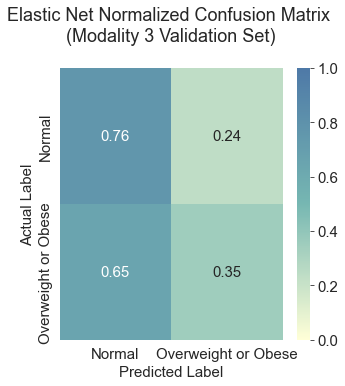

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_m3.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Elastic Net Normalized Confusion Matrix 
(Modality 3 Validation Set)
""",
                      file_name = 'conf_mat_elastic_net_m3.svg',
                      report    = True 
                     )

## kNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_m3.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_m3.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_m3.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits
KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=176)


In [13]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1483,0.503798,0.210164,1.750800,0.249463,kd_tree,30,manhattan,-1,176,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",0.578583,0.538418,0.584433,0.550095,0.601218,0.570549,0.023016,1
1302,0.389557,0.029860,1.462602,0.069181,kd_tree,20,manhattan,-1,176,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 20, 'met...",0.579054,0.538844,0.588152,0.544265,0.601083,0.570279,0.024537,2
930,0.020598,0.025703,1.577802,0.108084,brute,30,manhattan,-1,126,uniform,"{'algorithm': 'brute', 'leaf_size': 30, 'metri...",0.581858,0.556146,0.569250,0.549831,0.591866,0.569791,0.015606,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


AUC_avg (train): 0.5953271259560331
AUC_std (train): 0.003527155970046742
AUC_avg (validation): 0.570549437883079
AUC_std (validation): 0.023015804760134127


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


UAR_avg (train): 0.5095406805708717
UAR_std (train): 0.004219806920629583
UAR_avg (validation): 0.5060669118476525
UAR_std (validation): 0.004290719154424731


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

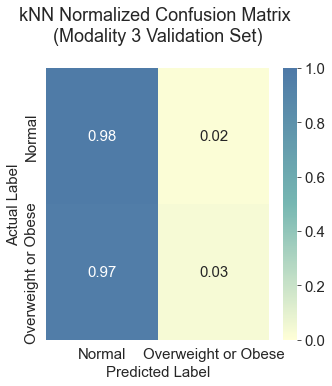

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_m3.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """kNN Normalized Confusion Matrix 
(Modality 3 Validation Set)
""",
                      file_name = 'conf_mat_knn_m3.svg'
                     )

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_m3.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_m3.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_m3.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features=26, min_samples_leaf=0.1,
                       min_samples_split=0.7000000000000001, random_state=27)


In [16]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3542,0.057400,0.026492,0.027800,0.016653,best,27,0.7,0.1,26,25,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586744,0.572474,0.582929,0.582666,0.59192,0.583347,0.006386,1
4545,0.036984,0.011931,0.018961,0.014399,best,27,0.7,0.1,26,10,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586744,0.572474,0.582929,0.582666,0.59192,0.583347,0.006386,1
4271,0.128399,0.113582,0.013401,0.010707,best,27,0.7,0.1,26,5,...,balanced,"{'splitter': 'best', 'random_state': 27, 'min_...",0.586744,0.572474,0.582929,0.582666,0.59192,0.583347,0.006386,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


AUC_avg (train): 0.5737098282680948
AUC_std (train): 0.006663339619397323
AUC_avg (validation): 0.5833467375956746
AUC_std (validation): 0.006385869059074816


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


UAR_avg (train): 0.5595386151040163
UAR_std (train): 0.0015630856697990692
UAR_avg (validation): 0.5620457080961188
UAR_std (validation): 0.010436412693301653


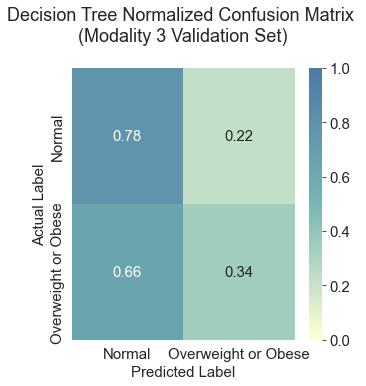

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_m3.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Decision Tree Normalized Confusion Matrix 
(Modality 3 Validation Set)
""",
                      file_name = 'conf_mat_tree_m3.svg'
                     )

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_m3.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_m3.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_m3.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=247, n_jobs=-1, random_state=27)


In [19]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1409,6.064489,0.861233,3.252859,1.079587,27,-1,247,10,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.570716,0.574987,0.594496,0.563781,0.576601,0.576116,0.010204,1
908,6.141093,0.498483,2.078924,0.457443,27,-1,405,10,2,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.564997,0.583925,0.597335,0.564241,0.569422,0.575984,0.012811,2
317,6.275071,0.369667,1.996600,0.408771,27,-1,405,10,2,sqrt,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.564997,0.583925,0.597335,0.564241,0.569422,0.575984,0.012811,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.9468379087025884
AUC_std (train): 0.0028982827136914946
AUC_avg (validation): 0.5761161720754389
AUC_std (validation): 0.010204123441620618


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


UAR_avg (train): 0.8699414547597595
UAR_std (train): 0.0017832897876517884
UAR_avg (validation): 0.563423372651159
UAR_std (validation): 0.012620579244397674


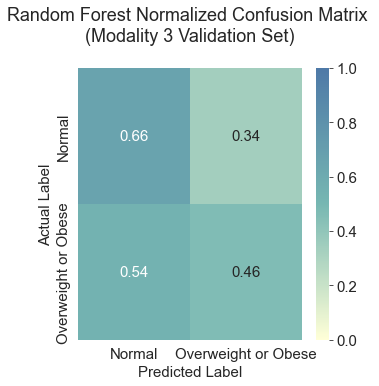

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['label','group'])
y = train_shuffled_df.label
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_m3.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix 
(Modality 3 Validation Set)
""",
                      file_name = 'conf_mat_rf_m3.svg'
                     )